This code covers the analysis steps involved using the school level aggregated data of neighborhood factors. 

#### Inputs
The inputs in this process would be the aggregated data files collated through the data processing phase. All the individual neighborhood factors are merged into one master file which is used for implementation of the analysis. Different tasks run in the analysis phase involve clustering, regression analysis and rank-ordering of schools.

#### Outputs
Outpus from this process would include the following: <br>
1. Clustering output involving grouping of all schools into 3 grouprs based on census data <br>
2. Model output from Logistic Regression analysis implemented on all of the clusters <br>
3. Probabilities from Logistic Regression model across schools are arranged in decreasing order to generate city level traffic collision risk for all the schools <br>
4. Borough level ranking is also developed and allocated funds are distrubuted based on school enrollment attribute across the identified high traffic collisions risk top 37 schools in NYC

In [1]:
# Loading Required libraries
%pylab inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
import seaborn as sns
sns.set(style="white", color_codes=True)

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


### NYC Schools

In [2]:
# Loading public schools data
public = pd.read_csv("NYC_Schools_Data/Public_Schools.csv")
public['NCESID'] = public['NCESID'].apply(str)
public['PUB_PRI_IND'] = 'Public'
public.columns

Index([u'NCESID', u'NAME', u'ADDRESS', u'CITY', u'STATE', u'ZIP', u'TELEPHONE',
       u'TYPE', u'STATUS', u'POPULATION', u'COUNTY', u'COUNTYFIPS', u'COUNTRY',
       u'LATITUDE', u'LONGITUDE', u'ENROLLMENT', u'START_GRAD', u'END_GRADE',
       u'FULL_TIME_', u'PUB_PRI_IND'],
      dtype='object')

In [3]:
# Laoding private schools data
private = pd.read_csv("NYC_Schools_Data/Private_Schools.csv")
private['PUB_PRI_IND'] = 'Private'
private['COUNTY'] = private['COUNTY'] + " COUNTY" 
private.columns

Index([u'NCESID', u'NAME', u'ADDRESS', u'CITY', u'STATE', u'ZIP', u'TELEPHONE',
       u'TYPE', u'STATUS', u'POPULATION', u'COUNTY', u'COUNTYFIPS', u'COUNTRY',
       u'LATITUDE', u'LONGITUDE', u'ENROLLMENT', u'START_GRAD', u'END_GRADE',
       u'FULL_TIME_', u'PUB_PRI_IND'],
      dtype='object')

In [4]:
# Appending both public and private schools data
nycSchools = pd.concat([public, private], axis=0)
print nycSchools.shape
print nycSchools.columns
print nycSchools.COUNTY.unique()

(2505, 20)
Index([u'NCESID', u'NAME', u'ADDRESS', u'CITY', u'STATE', u'ZIP', u'TELEPHONE',
       u'TYPE', u'STATUS', u'POPULATION', u'COUNTY', u'COUNTYFIPS', u'COUNTRY',
       u'LATITUDE', u'LONGITUDE', u'ENROLLMENT', u'START_GRAD', u'END_GRADE',
       u'FULL_TIME_', u'PUB_PRI_IND'],
      dtype='object')
['NEW YORK COUNTY' 'KINGS COUNTY' 'BRONX COUNTY' 'QUEENS COUNTY'
 'RICHMOND COUNTY']


In [5]:
# County to Borough Mapping since source data contains only county information
county2bor = {'NEW YORK COUNTY' : 'Manhattan',
              'KINGS COUNTY' : 'Brooklyn',
              'BRONX COUNTY' : 'Bronx',
              'QUEENS COUNTY' : 'Queens',
              'RICHMOND COUNTY' : 'Staten Island'}

BOROUGH = []

for i in nycSchools['COUNTY']:
    for j in county2bor:
        if i == j:
            BOROUGH.append(county2bor[j])

In [6]:
# Appending to the earlier data 
nycSchools['BOROUGH'] = BOROUGH
print nycSchools.shape
print nycSchools.columns
print nycSchools.BOROUGH.unique()

(2505, 21)
Index([u'NCESID', u'NAME', u'ADDRESS', u'CITY', u'STATE', u'ZIP', u'TELEPHONE',
       u'TYPE', u'STATUS', u'POPULATION', u'COUNTY', u'COUNTYFIPS', u'COUNTRY',
       u'LATITUDE', u'LONGITUDE', u'ENROLLMENT', u'START_GRAD', u'END_GRADE',
       u'FULL_TIME_', u'PUB_PRI_IND', u'BOROUGH'],
      dtype='object')
['Manhattan' 'Brooklyn' 'Bronx' 'Queens' 'Staten Island']


In [7]:
# Subset only for elementary and middle schools as target segment
print nycSchools.START_GRAD.unique()
print nycSchools.END_GRADE.unique()

elemidlist = ['08', '05', '03', '07', '01', '06', '02', '04', 'KG', 'PK', 'TK', 'T1']

nycSchools = nycSchools.loc[(nycSchools.END_GRADE.isin(elemidlist)),]
print nycSchools.END_GRADE.unique()

['10' '09' '06' 'KG' '07' 'PK' '03' '05' '02' '08' '04' 'N' '01' '11' 'UG'
 'T1' 'TK']
['12' '08' '05' '03' '07' '10' '01' '09' '06' '11' '02' '04' 'N' 'KG' 'PK'
 'UG' 'TK' 'T1']
['08' '05' '03' '07' '01' '06' '02' '04' 'KG' 'PK' 'TK' 'T1']


In [8]:
# Looking at variable data types
nycSchools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1658 entries, 2 to 789
Data columns (total 21 columns):
NCESID         1658 non-null object
NAME           1658 non-null object
ADDRESS        1658 non-null object
CITY           1658 non-null object
STATE          1658 non-null object
ZIP            1658 non-null int64
TELEPHONE      1658 non-null object
TYPE           1658 non-null int64
STATUS         1658 non-null int64
POPULATION     1658 non-null int64
COUNTY         1658 non-null object
COUNTYFIPS     1658 non-null int64
COUNTRY        1658 non-null object
LATITUDE       1658 non-null float64
LONGITUDE      1658 non-null float64
ENROLLMENT     1658 non-null int64
START_GRAD     1658 non-null object
END_GRADE      1658 non-null object
FULL_TIME_     1658 non-null int64
PUB_PRI_IND    1658 non-null object
BOROUGH        1658 non-null object
dtypes: float64(2), int64(7), object(12)
memory usage: 285.0+ KB


In [9]:
# Export for plotting in ArcGIS and CartoDB to generate plots for final report
# print nycSchools.shape
# nycSchools.to_csv("nycSchools.csv")

>__"Final number of schools left for performing the analysis is 1658 which are distributed across boroughs."__

In [10]:
# Computing number of private and public schools for analysis
print nycSchools.groupby(['PUB_PRI_IND']).size()

PUB_PRI_IND
Private     516
Public     1142
dtype: int64


>__"Out of 1658 schools, public are 1142 and private are 516."__

BOROUGH
Bronx            323
Brooklyn         557
Manhattan        301
Queens           393
Staten Island     84
dtype: int64


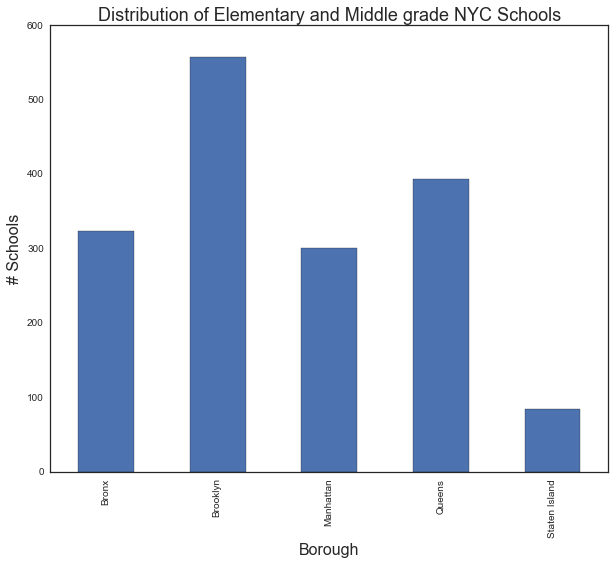

In [11]:
# Looking at distribution of schools across boroughs
print nycSchools.groupby(['BOROUGH']).size()
plt.figure(figsize=(10,8))
freqPlot = nycSchools.groupby(['BOROUGH']).size().plot(kind='bar')
freqPlot.set_title("Distribution of Elementary and Middle grade NYC Schools", fontsize=18)
freqPlot.set_xlabel("Borough", fontsize=16)
freqPlot.set_ylabel("# Schools", fontsize=16)

>__"Out of 1658 schools, Brooklyn seems to have highest share while Staten Island has the lowest share. This distribution of schools across boroughs would be used to ensure that finally selected top 37 risky schools have equitable representation across all the boroughs."__

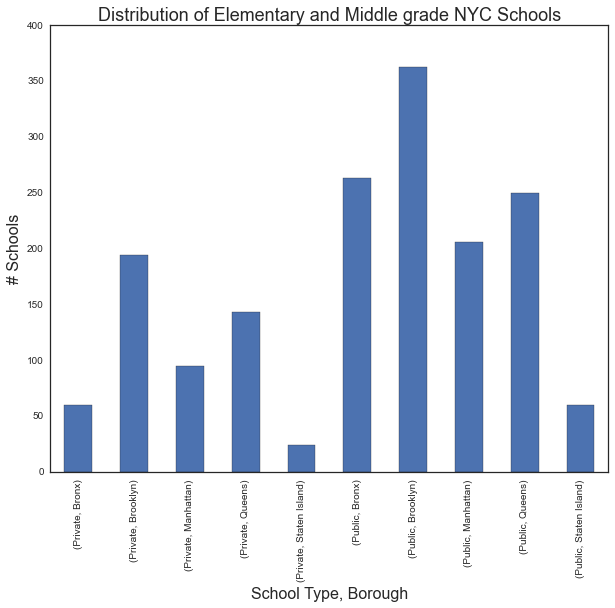

In [12]:
# Looking at distribution of schools across boroughs
plt.figure(figsize=(10,8))
freqPlot = nycSchools.groupby(['PUB_PRI_IND','BOROUGH']).size().plot(kind='bar')
freqPlot.set_title("Distribution of Elementary and Middle grade NYC Schools", fontsize=18)
freqPlot.set_xlabel("School Type, Borough", fontsize=16)
freqPlot.set_ylabel("# Schools", fontsize=16)

>__"Among private and private schools, similar trends are noticed like overall level except for one notable difference. Manhattan seems to have higher share than Bronx in terms of private schools while Bronx has higher than Manhattan in terms of public schools."__

### Traffic Collisions Mapping

In [13]:
# Uploading the traffic data extracted from ARCGIS
trafficCollisions = pd.read_csv("Traffic_Collisions_Data/School_Traffic_Mapping.csv")
trafficCollisions.columns

Index([u'NCESID', u'TOTAL_ACCIDENTS', u'TOTAL_INJURIES', u'ON_STR_TOP50',
       u'CROSS_STR_TOP50'],
      dtype='object')

In [14]:
trafficCollisions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2505 entries, 0 to 2504
Data columns (total 5 columns):
NCESID             2505 non-null object
TOTAL_ACCIDENTS    2505 non-null int64
TOTAL_INJURIES     2505 non-null int64
ON_STR_TOP50       2505 non-null int64
CROSS_STR_TOP50    2505 non-null int64
dtypes: int64(4), object(1)
memory usage: 117.4+ KB


In [15]:
# Performing data quality checks
print trafficCollisions.shape
print trafficCollisions['TOTAL_ACCIDENTS'].sum()
print trafficCollisions['TOTAL_INJURIES'].sum()
print trafficCollisions['ON_STR_TOP50'].sum()
print trafficCollisions['CROSS_STR_TOP50'].sum()

(2505, 5)
18142
4470
3296
3776


In [16]:
# Merging traffic collisions with schools data
nycSchools1 = pd.merge(left=nycSchools, right=trafficCollisions, how='left', on='NCESID')
print nycSchools1.shape
print nycSchools1.columns

(1658, 25)
Index([u'NCESID', u'NAME', u'ADDRESS', u'CITY', u'STATE', u'ZIP', u'TELEPHONE',
       u'TYPE', u'STATUS', u'POPULATION', u'COUNTY', u'COUNTYFIPS', u'COUNTRY',
       u'LATITUDE', u'LONGITUDE', u'ENROLLMENT', u'START_GRAD', u'END_GRADE',
       u'FULL_TIME_', u'PUB_PRI_IND', u'BOROUGH', u'TOTAL_ACCIDENTS',
       u'TOTAL_INJURIES', u'ON_STR_TOP50', u'CROSS_STR_TOP50'],
      dtype='object')


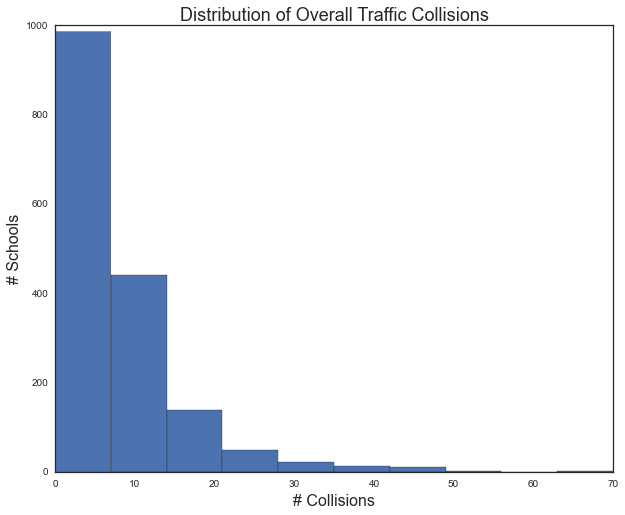

In [17]:
# Plotting the overall traffic distributions
plt.figure(figsize=(10,8))
plt.hist(nycSchools1['TOTAL_ACCIDENTS'])
plt.title("Distribution of Overall Traffic Collisions", fontsize=18)
plt.xlabel("# Collisions", fontsize=16)
plt.ylabel("# Schools", fontsize=16)

>__"Almost 60% of the schools have a low accident rate i.e. less than 10 collisions across the years 2013, 2014 and 2015 within 300 feet of each school location. Accidents are defined as the total number of collisions that occur and not just confined to those that result in injuries or fatalities."__

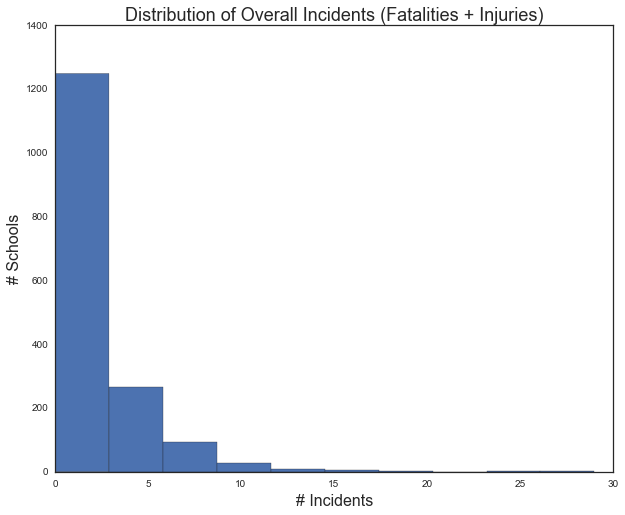

In [18]:
# Plotting the overall injury distributions
plt.figure(figsize=(10,8))
plt.hist(nycSchools1['TOTAL_INJURIES'])
plt.title("Distribution of Overall Incidents (Fatalities + Injuries)", fontsize=18)
plt.xlabel("# Incidents", fontsize=16)
plt.ylabel("# Schools", fontsize=16)

>__"Similar to accidents, almost 80% of the schools have a low incident rate i.e. less than 5 incidents across the years 2013, 2014 and 2015 within 300 feet of each school location. Incidents are defined as the total number of injuries and fatalities that happen in collisions."__

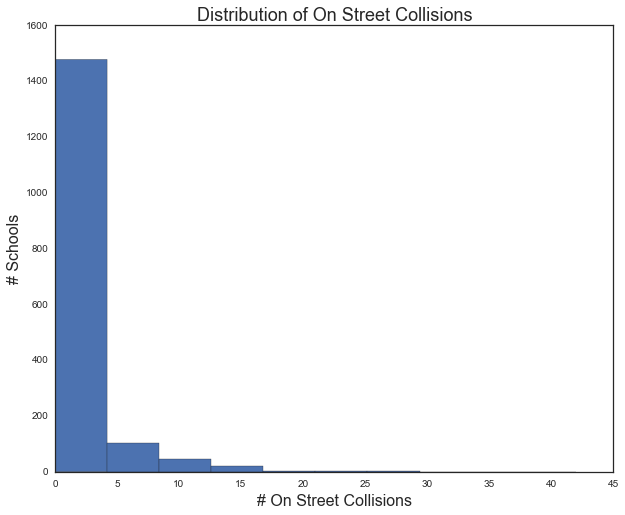

In [19]:
# Plotting the distributions across top 50 on streets
plt.figure(figsize=(10,8))
plt.hist(nycSchools1['ON_STR_TOP50'])
plt.title("Distribution of On Street Collisions", fontsize=18)
plt.xlabel("# On Street Collisions", fontsize=16)
plt.ylabel("# Schools", fontsize=16)

In [20]:
# Export for plotting in ArcGIS and CartoDB to generate plots for final report
# print nycSchools1.shape
# nycSchools1.to_csv("nycSchools_collisions.csv")

### Precinct Mapping

In [21]:
# Loading the data
precincts = pd.read_csv("NYPD_Summons_Data/School_Precinct_Mapping.csv")

# Subset only school id and precinct
precincts = precincts[['NCESID', 'precinct']]
print precincts.columns
print precincts.shape
print len(precincts['precinct'].unique())

Index([u'NCESID', u'precinct'], dtype='object')
(2503, 2)
76


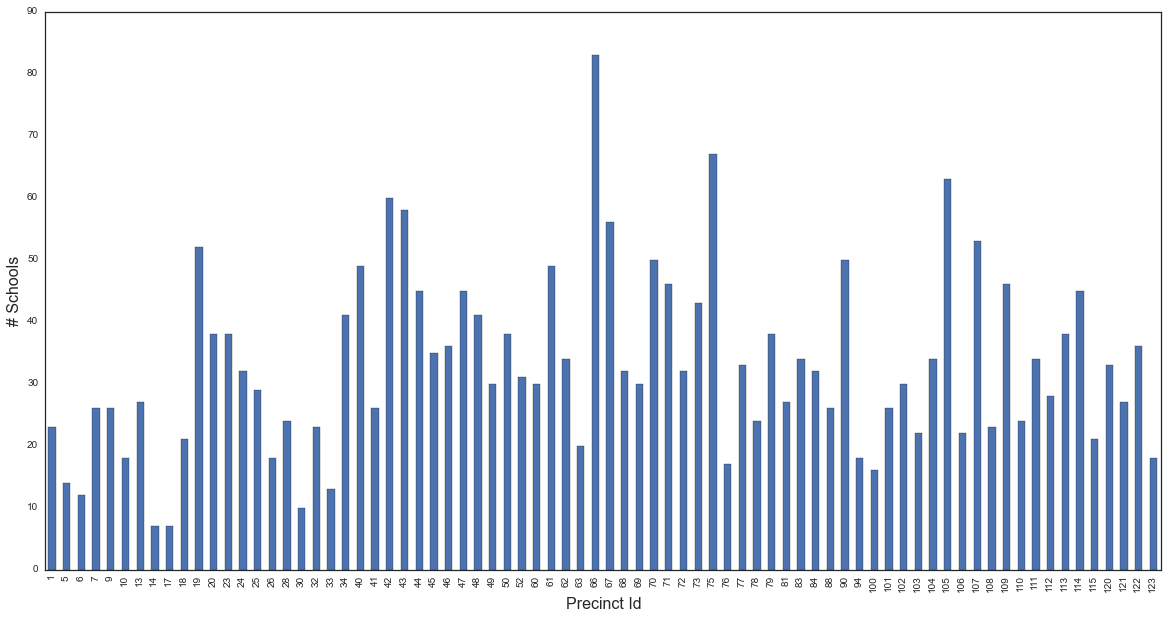

In [22]:
# Number of Schools by Precinct
plt.figure(figsize=(20,10))
freqPlot = precincts.groupby('precinct').size().plot(kind='bar')
freqPlot.set_xlabel("Precinct Id", fontsize=16)
freqPlot.set_ylabel("# Schools", fontsize=16)

#### Precinct moving summons mapping to Schools

In [23]:
# Loading the data
summons = pd.read_csv("NYPD_Summons_Data/precinct_summons.csv")
summons.rename(columns={'index':'precinct'}, inplace=True)
summons = summons[summons.columns[1:]]

print summons.columns
print summons.shape

Index([u'precinct', u'Cell Phone', u'Disobey Steady Red Signal',
       u'Disobey Traffic Control Device', u'Improper Turn', u'Safety Belt',
       u'Tinted Windows'],
      dtype='object')
(77, 7)


In [24]:
# Normalize the data points using total moving summons given for years 2013, 2014 and 2015 i.e. 2301951.0
# This value is computed in the python code named Precinct Summons Mapping
summons[summons.columns[1:]] = summons[summons.columns[1:]]/2301951.0
summons.head()

,precinct,Cell Phone,Disobey Steady Red Signal,Disobey Traffic Control Device,Improper Turn,Safety Belt,Tinted Windows
0,1,0.003140,0.001565,0.002358,0.001017,0.001736,0.000674
1,5,0.000682,0.001371,0.002087,0.002291,0.000683,0.000219
2,6,0.001857,0.001720,0.001454,0.001317,0.001470,0.000217
3,7,0.001636,0.001361,0.001969,0.001272,0.001013,0.000371
4,9,0.002323,0.001447,0.001690,0.001115,0.001336,0.000159


In [25]:
# Merging moving summons data with schools
nycSchools2 = pd.merge(left=nycSchools1, right=precincts, how='left', on='NCESID')
print nycSchools2.shape
print nycSchools2.columns

# Checking for any missing values after merge
print nycSchools2['precinct'].isnull().sum()

# Dropping the school with no precinct mapping
nycSchools2 = nycSchools2.dropna()
print nycSchools2.shape
print nycSchools2.columns

(1658, 26)
Index([u'NCESID', u'NAME', u'ADDRESS', u'CITY', u'STATE', u'ZIP', u'TELEPHONE',
       u'TYPE', u'STATUS', u'POPULATION', u'COUNTY', u'COUNTYFIPS', u'COUNTRY',
       u'LATITUDE', u'LONGITUDE', u'ENROLLMENT', u'START_GRAD', u'END_GRADE',
       u'FULL_TIME_', u'PUB_PRI_IND', u'BOROUGH', u'TOTAL_ACCIDENTS',
       u'TOTAL_INJURIES', u'ON_STR_TOP50', u'CROSS_STR_TOP50', u'precinct'],
      dtype='object')
1
(1657, 26)
Index([u'NCESID', u'NAME', u'ADDRESS', u'CITY', u'STATE', u'ZIP', u'TELEPHONE',
       u'TYPE', u'STATUS', u'POPULATION', u'COUNTY', u'COUNTYFIPS', u'COUNTRY',
       u'LATITUDE', u'LONGITUDE', u'ENROLLMENT', u'START_GRAD', u'END_GRADE',
       u'FULL_TIME_', u'PUB_PRI_IND', u'BOROUGH', u'TOTAL_ACCIDENTS',
       u'TOTAL_INJURIES', u'ON_STR_TOP50', u'CROSS_STR_TOP50', u'precinct'],
      dtype='object')


In [26]:
# Merging moving summons data with schools
nycSchools3 = pd.merge(left=nycSchools2, right=summons, how='left', on='precinct')
print nycSchools3.shape
print nycSchools3.columns

# Checking for any missing values after merge
print nycSchools3['Safety Belt'].isnull().sum()

(1657, 32)
Index([u'NCESID', u'NAME', u'ADDRESS', u'CITY', u'STATE', u'ZIP', u'TELEPHONE',
       u'TYPE', u'STATUS', u'POPULATION', u'COUNTY', u'COUNTYFIPS', u'COUNTRY',
       u'LATITUDE', u'LONGITUDE', u'ENROLLMENT', u'START_GRAD', u'END_GRADE',
       u'FULL_TIME_', u'PUB_PRI_IND', u'BOROUGH', u'TOTAL_ACCIDENTS',
       u'TOTAL_INJURIES', u'ON_STR_TOP50', u'CROSS_STR_TOP50', u'precinct',
       u'Cell Phone', u'Disobey Steady Red Signal',
       u'Disobey Traffic Control Device', u'Improper Turn', u'Safety Belt',
       u'Tinted Windows'],
      dtype='object')
0


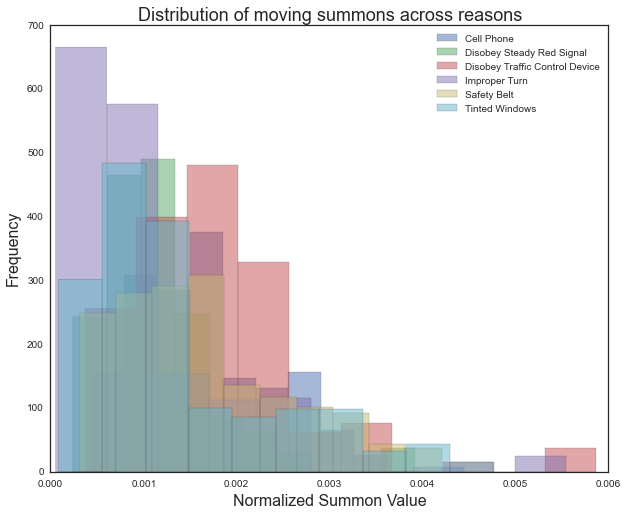

In [27]:
# Plotting histograms for all the summons related variables
plt.figure(figsize=(10,8))

for i in nycSchools3.columns[26:]:
    plt.hist(nycSchools3[i], alpha=0.5, label=i)

plt.legend(loc='upper right')
plt.title("Distribution of moving summons across reasons", fontsize=18)
plt.xlabel("Normalized Summon Value", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

>__"From the above histogram plot, moving summons related to categories like disobeying traffic control device, disobeying red signal, improper turn and safety belt seems to have a higher representation in the precincts related to school locations."__

In [28]:
# Export for plotting in ArcGIS and CartoDB to generate plots for final report
# print nycSchools3.shape
# nycSchools3.to_csv("nycSchools_nypdsummons.csv")

### 311 Calls Mapping

In [29]:
data311 = pd.read_csv("311_Data/School_311_Mapping.csv")
data311.columns

Index([u'NCESID', u'Count_311_Calls'], dtype='object')

In [31]:
# Merging moving summons data with schools
nycSchools4 = pd.merge(left=nycSchools3, right=data311, how='left', on='NCESID')
print nycSchools4.shape
print nycSchools4.columns

# Checking for any missing values after merge
print nycSchools4['Count_311_Calls'].isnull().sum()

(1657, 33)
Index([u'NCESID', u'NAME', u'ADDRESS', u'CITY', u'STATE', u'ZIP', u'TELEPHONE',
       u'TYPE', u'STATUS', u'POPULATION', u'COUNTY', u'COUNTYFIPS', u'COUNTRY',
       u'LATITUDE', u'LONGITUDE', u'ENROLLMENT', u'START_GRAD', u'END_GRADE',
       u'FULL_TIME_', u'PUB_PRI_IND', u'BOROUGH', u'TOTAL_ACCIDENTS',
       u'TOTAL_INJURIES', u'ON_STR_TOP50', u'CROSS_STR_TOP50', u'precinct',
       u'Cell Phone', u'Disobey Steady Red Signal',
       u'Disobey Traffic Control Device', u'Improper Turn', u'Safety Belt',
       u'Tinted Windows', u'Count_311_Calls'],
      dtype='object')
194


In [32]:
# Filling missing values with zero
nycSchools4['Count_311_Calls'] = nycSchools4['Count_311_Calls'].fillna(0)

# Checking for any missing values after merge
print nycSchools4['Count_311_Calls'].isnull().sum()

0


In [33]:
# Normalize the data points using total 311 calls for years 2013, 2014 and 2015 i.e. 283575.0
# This value is computed in the python code named Precinct 311 Street Quality Counts
nycSchools4[nycSchools4.columns[32:]] = nycSchools4[nycSchools4.columns[32:]]/283575.0

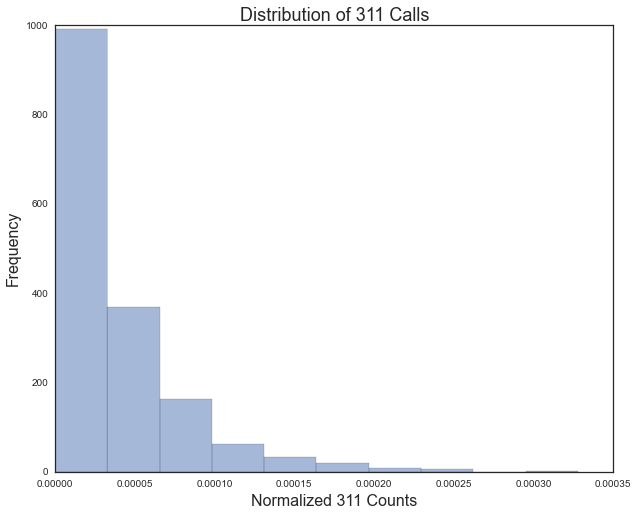

In [34]:
# Plotting histograms for the normalized 311 call related variable
plt.figure(figsize=(10,8))
plt.hist(nycSchools4['Count_311_Calls'], alpha=0.5)
plt.title("Distribution of 311 Calls", fontsize=18)
plt.xlabel("Normalized 311 Counts", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

>__"In terms of street quality conditions within 300 feet of school locations, 311 calls aggregated across years 2013, 2014 and 2015 have a lower share of volumne in comparison to total 311 calls made in these years."__

In [35]:
# Export for plotting in ArcGIS and CartoDB to generate plots for final report
# print nycSchools4.shape
# nycSchools4.to_csv("nycSchools_311calls.csv")

### Census data Mapping

In [36]:
# Loading census data
census = pd.read_csv("Census_Data/School_Census_Mapping.csv")
census.rename(columns={'ID2':'Census_Track',
                       'Estimate__RACE___One_race___White':'White_Popn',
                       'Estimate__RACE___One_race___Black_or_African_American':'Black_Popn',
                       'Estimate__RACE___One_race___Asian':'Asian_Popn',
                       'Estimate__HISPANIC_OR_LATINO_AND_RACE___Total_population___Hispa':'Hispanic_Lation_Popn'}
              , inplace=True)
print census.shape
print census.columns

(2503, 10)
Index([u'NCESID', u'Census_Track', u'Geography',
       u'Estimate__RACE___Total_population', u'White_Popn', u'Black_Popn',
       u'Asian_Popn', u'Estimate__RACE___One_race___Some_other_race',
       u'Hispanic_Lation_Popn',
       u'Estimate__HISPANIC_OR_LATINO_AND_RACE___Total_population___Not_H'],
      dtype='object')


In [37]:
# Subsetting the features
census = census[['NCESID', 'Census_Track', 'White_Popn', 'Black_Popn', 'Asian_Popn']]
census.columns

Index([u'NCESID', u'Census_Track', u'White_Popn', u'Black_Popn',
       u'Asian_Popn'],
      dtype='object')

In [38]:
# Merging demographics data with schools
nycSchools5 = pd.merge(left=nycSchools4, right=census, how='left', on='NCESID')
print nycSchools5.shape
print nycSchools5.columns

# Checking for any missing values after merge
print nycSchools5['Census_Track'].isnull().sum()

(1657, 37)
Index([u'NCESID', u'NAME', u'ADDRESS', u'CITY', u'STATE', u'ZIP', u'TELEPHONE',
       u'TYPE', u'STATUS', u'POPULATION', u'COUNTY', u'COUNTYFIPS', u'COUNTRY',
       u'LATITUDE', u'LONGITUDE', u'ENROLLMENT', u'START_GRAD', u'END_GRADE',
       u'FULL_TIME_', u'PUB_PRI_IND', u'BOROUGH', u'TOTAL_ACCIDENTS',
       u'TOTAL_INJURIES', u'ON_STR_TOP50', u'CROSS_STR_TOP50', u'precinct',
       u'Cell Phone', u'Disobey Steady Red Signal',
       u'Disobey Traffic Control Device', u'Improper Turn', u'Safety Belt',
       u'Tinted Windows', u'Count_311_Calls', u'Census_Track', u'White_Popn',
       u'Black_Popn', u'Asian_Popn'],
      dtype='object')
0


In [39]:
# Checking for values within Census_Track variable
print nycSchools5['Census_Track'].head()

0    36047012902
1    36047020500
2    36047018300
3    36047023500
4    36047100800
Name: Census_Track, dtype: int64


#### Census tract education mapping

In [40]:
# Loading census tract education mapping data
censustract_edu = pd.read_csv("Census_Data/Census_tract_education_mapping.csv")
print censustract_edu.shape
print censustract_edu.columns

(2167, 26)
Index([u'Census_Track', u'Total', u'No_schooling_completed', u'Nursery_school',
       u'Kindergarten', u'grade1', u'grade2', u'grad3', u'grade4', u'grade5',
       u'grade6', u'grade7', u'grade8', u'grade9', u'grade10', u'grade11',
       u'grade12_no_diploma', u'Regular_high_school_diploma',
       u'GED_or_alternative_credential', u'Some_college_lessthan1year',
       u'Some_college,_1ormoreyears_nodegree', u'Associates_degree',
       u'Bachelors_degree', u'Masters_degree', u'Professional_school_degree',
       u'Doctorate_degree'],
      dtype='object')


In [41]:
# Merging census tract education data with schools
nycSchools6 = pd.merge(left=nycSchools5, right=censustract_edu, how='left', on='Census_Track')
print nycSchools6.shape
print nycSchools6.columns

# Checking for any missing values after merge
nycSchools6[[u'Census_Track', u'Total', u'No_schooling_completed', u'Nursery_school',
       u'Kindergarten', u'grade1', u'grade2', u'grad3', u'grade4', u'grade5',
       u'grade6', u'grade7', u'grade8', u'grade9', u'grade10', u'grade11',
       u'grade12_no_diploma', u'Regular_high_school_diploma',
       u'GED_or_alternative_credential', u'Some_college_lessthan1year',
       u'Some_college,_1ormoreyears_nodegree', u'Associates_degree',
       u'Bachelors_degree', u'Masters_degree', u'Professional_school_degree',
       u'Doctorate_degree']].isnull().sum()

(1657, 62)
Index([u'NCESID', u'NAME', u'ADDRESS', u'CITY', u'STATE', u'ZIP', u'TELEPHONE',
       u'TYPE', u'STATUS', u'POPULATION', u'COUNTY', u'COUNTYFIPS', u'COUNTRY',
       u'LATITUDE', u'LONGITUDE', u'ENROLLMENT', u'START_GRAD', u'END_GRADE',
       u'FULL_TIME_', u'PUB_PRI_IND', u'BOROUGH', u'TOTAL_ACCIDENTS',
       u'TOTAL_INJURIES', u'ON_STR_TOP50', u'CROSS_STR_TOP50', u'precinct',
       u'Cell Phone', u'Disobey Steady Red Signal',
       u'Disobey Traffic Control Device', u'Improper Turn', u'Safety Belt',
       u'Tinted Windows', u'Count_311_Calls', u'Census_Track', u'White_Popn',
       u'Black_Popn', u'Asian_Popn', u'Total', u'No_schooling_completed',
       u'Nursery_school', u'Kindergarten', u'grade1', u'grade2', u'grad3',
       u'grade4', u'grade5', u'grade6', u'grade7', u'grade8', u'grade9',
       u'grade10', u'grade11', u'grade12_no_diploma',
       u'Regular_high_school_diploma', u'GED_or_alternative_credential',
       u'Some_college_lessthan1year', u'Some_colle

Census_Track                           0
Total                                  0
No_schooling_completed                 0
Nursery_school                         0
Kindergarten                           0
grade1                                 0
grade2                                 0
grad3                                  0
grade4                                 0
grade5                                 0
grade6                                 0
grade7                                 0
grade8                                 0
grade9                                 0
grade10                                0
grade11                                0
grade12_no_diploma                     0
Regular_high_school_diploma            0
GED_or_alternative_credential          0
Some_college_lessthan1year             0
Some_college,_1ormoreyears_nodegree    0
Associates_degree                      0
Bachelors_degree                       0
Masters_degree                         0
Professional_sch

#### Census tract income mapping

In [42]:
# Loading census tract education mapping data
censustract_inc = pd.read_csv("Census_Data/Census_tract_income_mapping.csv")
print censustract_inc.shape
print censustract_inc.columns

(2167, 13)
Index([u'Census_Track', u'Total_Households', u'Mean_Inc_All_Households',
       u'Per_Capita_Inc_Total', u'Mean_Per_Capita_Inc_Total',
       u'Per_Capita_Inc_White', u'Mean_Per_Capita_Inc_White',
       u'Per_Capita_Inc_Black', u'Mean_Per_Capita_Inc_Black',
       u'Per_Capita_Inc_Asian', u'Mean_Per_Capita_Inc_Asian',
       u'Per_Capita_Inc_Hispanic', u'Mean_Per_Capita_Inc_Hispanic'],
      dtype='object')


In [43]:
# Merging census tract income data with schools
nycSchools7 = pd.merge(left=nycSchools6, right=censustract_inc, how='left', on='Census_Track')
print nycSchools7.shape
print nycSchools7.columns

# Checking for any missing values after merge
nycSchools7[[u'Census_Track', u'Total_Households', u'Mean_Inc_All_Households',
       u'Per_Capita_Inc_Total', u'Mean_Per_Capita_Inc_Total',
       u'Per_Capita_Inc_White', u'Mean_Per_Capita_Inc_White',
       u'Per_Capita_Inc_Black', u'Mean_Per_Capita_Inc_Black',
       u'Per_Capita_Inc_Asian', u'Mean_Per_Capita_Inc_Asian',
       u'Per_Capita_Inc_Hispanic', u'Mean_Per_Capita_Inc_Hispanic']].isnull().sum()

(1657, 74)
Index([u'NCESID', u'NAME', u'ADDRESS', u'CITY', u'STATE', u'ZIP', u'TELEPHONE',
       u'TYPE', u'STATUS', u'POPULATION', u'COUNTY', u'COUNTYFIPS', u'COUNTRY',
       u'LATITUDE', u'LONGITUDE', u'ENROLLMENT', u'START_GRAD', u'END_GRADE',
       u'FULL_TIME_', u'PUB_PRI_IND', u'BOROUGH', u'TOTAL_ACCIDENTS',
       u'TOTAL_INJURIES', u'ON_STR_TOP50', u'CROSS_STR_TOP50', u'precinct',
       u'Cell Phone', u'Disobey Steady Red Signal',
       u'Disobey Traffic Control Device', u'Improper Turn', u'Safety Belt',
       u'Tinted Windows', u'Count_311_Calls', u'Census_Track', u'White_Popn',
       u'Black_Popn', u'Asian_Popn', u'Total', u'No_schooling_completed',
       u'Nursery_school', u'Kindergarten', u'grade1', u'grade2', u'grad3',
       u'grade4', u'grade5', u'grade6', u'grade7', u'grade8', u'grade9',
       u'grade10', u'grade11', u'grade12_no_diploma',
       u'Regular_high_school_diploma', u'GED_or_alternative_credential',
       u'Some_college_lessthan1year', u'Some_colle

Census_Track                      0
Total_Households                  0
Mean_Inc_All_Households           5
Per_Capita_Inc_Total              0
Mean_Per_Capita_Inc_Total         5
Per_Capita_Inc_White              5
Mean_Per_Capita_Inc_White        29
Per_Capita_Inc_Black              5
Mean_Per_Capita_Inc_Black       176
Per_Capita_Inc_Asian              5
Mean_Per_Capita_Inc_Asian       292
Per_Capita_Inc_Hispanic           5
Mean_Per_Capita_Inc_Hispanic     18
dtype: int64

In [44]:
# Dropping variables with many missing values based on above output
# And replacing the ones with few missing values with zeros
nycSchools7.drop(['Mean_Per_Capita_Inc_White', 'Mean_Per_Capita_Inc_Black',
                  'Mean_Per_Capita_Inc_Asian', 'Mean_Per_Capita_Inc_Hispanic'],
                 axis=1,
                 inplace=True)
nycSchools7= nycSchools7.fillna(0)

# Checking for missing values
nycSchools7.isnull().sum()

NCESID                                 0
NAME                                   0
ADDRESS                                0
CITY                                   0
STATE                                  0
ZIP                                    0
TELEPHONE                              0
TYPE                                   0
STATUS                                 0
POPULATION                             0
COUNTY                                 0
COUNTYFIPS                             0
COUNTRY                                0
LATITUDE                               0
LONGITUDE                              0
ENROLLMENT                             0
START_GRAD                             0
END_GRADE                              0
FULL_TIME_                             0
PUB_PRI_IND                            0
BOROUGH                                0
TOTAL_ACCIDENTS                        0
TOTAL_INJURIES                         0
ON_STR_TOP50                           0
CROSS_STR_TOP50 

In [45]:
# Export for plotting in ArcGIS and CartoDB to generate plots for final report
# print nycSchools7.shape
# nycSchools7.to_csv("nycSchools_census.csv")

## Analysis and Results

### Computing Risk Metric and Converting it to binary outcome

Risk metric is defined as the ratio of total injuries to total accidents across any group. This metric helps differentiate between groups in terms of higher to lower injury risk with respect to any traffic collision. It can be looked upon as per-capita injury metric with respect to traffic collisions.

In [46]:
# Computing risk metric ratio
nycSchools7['RISK'] = nycSchools7['TOTAL_INJURIES']/nycSchools7['TOTAL_ACCIDENTS']
nycSchools7[['TOTAL_ACCIDENTS', 'TOTAL_INJURIES', 'RISK']].head()

,TOTAL_ACCIDENTS,TOTAL_INJURIES,RISK
0,5,2,0.400000
1,7,2,0.285714
2,2,0,0.000000
3,6,2,0.333333
4,2,0,0.000000


In [47]:
# Replacing missing values with zero's and capping upper value at 1
nycSchools7['RISK'] = nycSchools7['RISK'].fillna(0)
nycSchools7.loc[nycSchools7['RISK'] > 1, 'RISK'] = 1

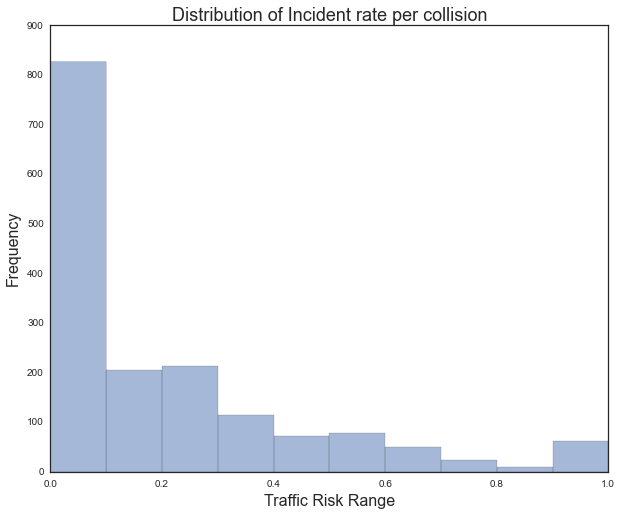

In [48]:
# Plotting histograms of the risk distribution
plt.figure(figsize=(10,8))
plt.hist(nycSchools7['RISK'], alpha=0.5)
plt.title("Distribution of Incident rate per collision", fontsize=18)
plt.xlabel("Traffic Risk Range", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

>__"From the above plot, 50% of the schools tend to have risk less than 10% which implies that on a average total injuries resulting from the collisions would be less than 10. Remaining 50% of schools show a variation between 0.1 to 1 values and these differences would be quantified using certain input factors under the modeling exercise."__

In [49]:
# Creating indicator variable for risk metric in comparison with overall risk value in 2015
# Risk metric for NYC is 0.2389
nycSchools7['IND_RISK'] = (nycSchools7['RISK'] > 0.2389).astype(int)
nycSchools7.groupby('IND_RISK').size()

IND_RISK
0    1125
1     532
dtype: int64

In [50]:
nycSchools7.groupby('IND_RISK').mean()

,ZIP,TYPE,STATUS,POPULATION,COUNTYFIPS,LATITUDE,LONGITUDE,ENROLLMENT,FULL_TIME_,TOTAL_ACCIDENTS,...,Doctorate_degree,Total_Households,Mean_Inc_All_Households,Per_Capita_Inc_Total,Mean_Per_Capita_Inc_Total,Per_Capita_Inc_White,Per_Capita_Inc_Black,Per_Capita_Inc_Asian,Per_Capita_Inc_Hispanic,RISK
IND_RISK,,,,,,,,,,,,,,,,,,,,,
0,10831.483556,1.474667,1.030222,501.171556,36053.259556,40.725246,-73.921890,467.680000,33.455111,6.108444,...,0.012683,1836.783111,77606.705778,4808.298667,31924.110222,43.270044,26.868533,11.830044,27.731022,0.047689
1,10885.883459,1.515038,1.030075,490.879699,36047.379699,40.730524,-73.911203,457.913534,32.951128,8.986842,...,0.008982,1534.312030,64798.285714,4259.562030,24946.669173,33.779135,35.095865,9.288158,32.126692,0.490196


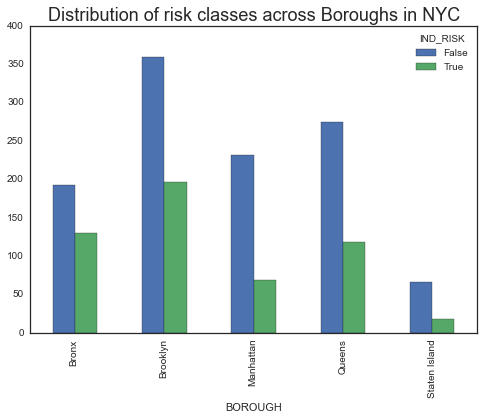

In [51]:
pd.crosstab(nycSchools7.BOROUGH, nycSchools7.IND_RISK.astype(bool)).plot(kind='bar')
plt.title("Distribution of risk classes across Boroughs in NYC", fontsize=18)

In [52]:
# Export for plotting in ArcGIS and CartoDB to generate plots for final report
# print nycSchools7.shape
# nycSchools7.to_csv("nycSchools_trafficrisk.csv")

### Distributions of variables across risk classes

In [53]:
nycSchools7.columns

Index([u'NCESID', u'NAME', u'ADDRESS', u'CITY', u'STATE', u'ZIP', u'TELEPHONE',
       u'TYPE', u'STATUS', u'POPULATION', u'COUNTY', u'COUNTYFIPS', u'COUNTRY',
       u'LATITUDE', u'LONGITUDE', u'ENROLLMENT', u'START_GRAD', u'END_GRADE',
       u'FULL_TIME_', u'PUB_PRI_IND', u'BOROUGH', u'TOTAL_ACCIDENTS',
       u'TOTAL_INJURIES', u'ON_STR_TOP50', u'CROSS_STR_TOP50', u'precinct',
       u'Cell Phone', u'Disobey Steady Red Signal',
       u'Disobey Traffic Control Device', u'Improper Turn', u'Safety Belt',
       u'Tinted Windows', u'Count_311_Calls', u'Census_Track', u'White_Popn',
       u'Black_Popn', u'Asian_Popn', u'Total', u'No_schooling_completed',
       u'Nursery_school', u'Kindergarten', u'grade1', u'grade2', u'grad3',
       u'grade4', u'grade5', u'grade6', u'grade7', u'grade8', u'grade9',
       u'grade10', u'grade11', u'grade12_no_diploma',
       u'Regular_high_school_diploma', u'GED_or_alternative_credential',
       u'Some_college_lessthan1year', u'Some_college,_1ormore

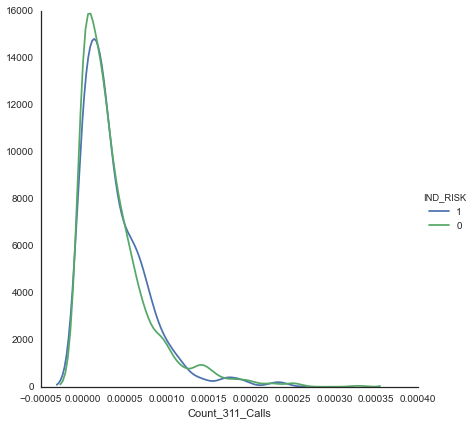

In [54]:
sns.FacetGrid(nycSchools7, hue="IND_RISK", size=6) \
   .map(sns.kdeplot, "Count_311_Calls") \
   .add_legend()

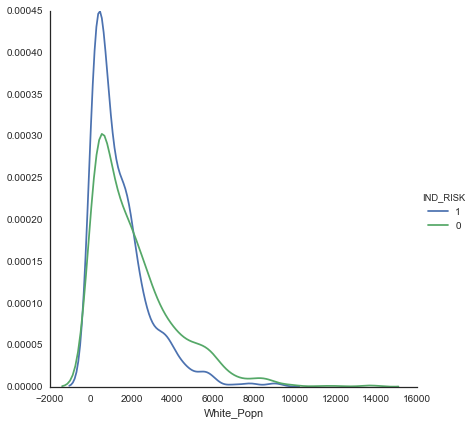

In [55]:
sns.FacetGrid(nycSchools7, hue="IND_RISK", size=6) \
   .map(sns.kdeplot, "White_Popn") \
   .add_legend()

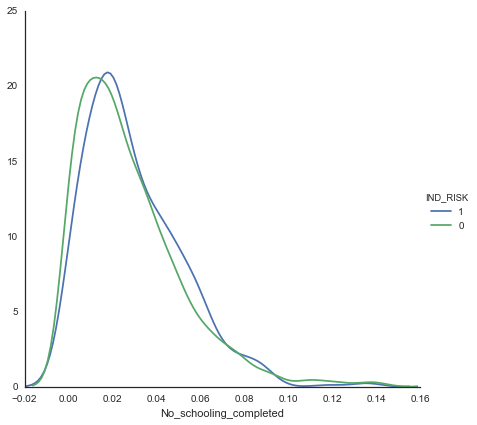

In [56]:
sns.FacetGrid(nycSchools7, hue="IND_RISK", size=6) \
   .map(sns.kdeplot, "No_schooling_completed") \
   .add_legend()

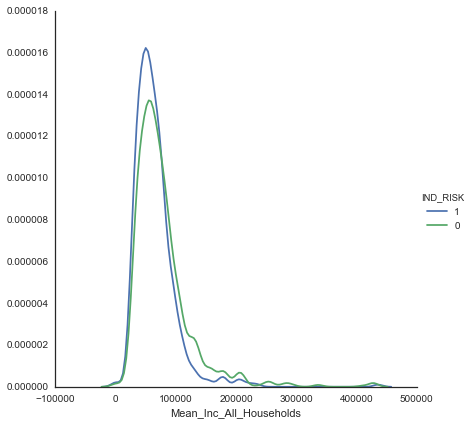

In [57]:
sns.FacetGrid(nycSchools7, hue="IND_RISK", size=6) \
   .map(sns.kdeplot, "Mean_Inc_All_Households") \
   .add_legend()

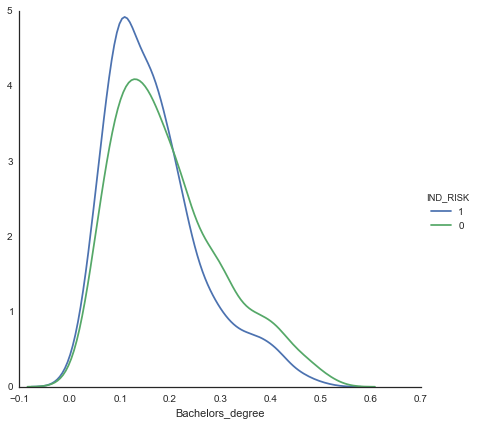

In [58]:
sns.FacetGrid(nycSchools7, hue="IND_RISK", size=6) \
   .map(sns.kdeplot, "Bachelors_degree") \
   .add_legend()

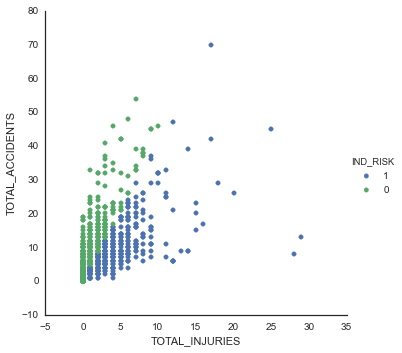

In [59]:
sns.FacetGrid(nycSchools7, hue="IND_RISK", size=5) \
              .map(plt.scatter, "TOTAL_INJURIES", "TOTAL_ACCIDENTS") \
              .add_legend()

### Clustering

Clustering of schools only on census data

In [60]:
# Subset data for clustering
clusterSchools = nycSchools7[['White_Popn',
       u'Black_Popn', u'Asian_Popn', u'Total', u'No_schooling_completed',
       u'Nursery_school', u'Kindergarten', u'grade1', u'grade2', u'grad3',
       u'grade4', u'grade5', u'grade6', u'grade7', u'grade8', u'grade9',
       u'grade10', u'grade11', u'grade12_no_diploma',
       u'Regular_high_school_diploma', u'GED_or_alternative_credential',
       u'Some_college_lessthan1year', u'Some_college,_1ormoreyears_nodegree',
       u'Associates_degree', u'Bachelors_degree', u'Masters_degree',
       u'Professional_school_degree', u'Doctorate_degree', u'Total_Households',
       u'Mean_Inc_All_Households', u'Per_Capita_Inc_Total',
       u'Mean_Per_Capita_Inc_Total', u'Per_Capita_Inc_White',
       u'Per_Capita_Inc_Black', u'Per_Capita_Inc_Asian',
       u'Per_Capita_Inc_Hispanic']]

print clusterSchools.shape
print clusterSchools.columns

(1657, 36)
Index([u'White_Popn', u'Black_Popn', u'Asian_Popn', u'Total',
       u'No_schooling_completed', u'Nursery_school', u'Kindergarten',
       u'grade1', u'grade2', u'grad3', u'grade4', u'grade5', u'grade6',
       u'grade7', u'grade8', u'grade9', u'grade10', u'grade11',
       u'grade12_no_diploma', u'Regular_high_school_diploma',
       u'GED_or_alternative_credential', u'Some_college_lessthan1year',
       u'Some_college,_1ormoreyears_nodegree', u'Associates_degree',
       u'Bachelors_degree', u'Masters_degree', u'Professional_school_degree',
       u'Doctorate_degree', u'Total_Households', u'Mean_Inc_All_Households',
       u'Per_Capita_Inc_Total', u'Mean_Per_Capita_Inc_Total',
       u'Per_Capita_Inc_White', u'Per_Capita_Inc_Black',
       u'Per_Capita_Inc_Asian', u'Per_Capita_Inc_Hispanic'],
      dtype='object')


In [61]:
# Checking for data types of the variables since clustering is done only for numeric variables
clusterSchools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1657 entries, 0 to 1656
Data columns (total 36 columns):
White_Popn                             1657 non-null int64
Black_Popn                             1657 non-null int64
Asian_Popn                             1657 non-null int64
Total                                  1657 non-null int64
No_schooling_completed                 1657 non-null float64
Nursery_school                         1657 non-null float64
Kindergarten                           1657 non-null float64
grade1                                 1657 non-null float64
grade2                                 1657 non-null float64
grad3                                  1657 non-null float64
grade4                                 1657 non-null float64
grade5                                 1657 non-null float64
grade6                                 1657 non-null float64
grade7                                 1657 non-null float64
grade8                                 1657 non

In [62]:
# Required libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

X = preprocessing.StandardScaler().fit_transform(clusterSchools)

k = 3

kmeans = KMeans(n_clusters = k, n_init = 100)
kmeans.fit(X)
kmeans.labels_

array([1, 1, 1, ..., 1, 2, 1])

In [63]:
# Merging the cluster labels to the original data
nycSchools7['cluster'] = pd.DataFrame(kmeans.labels_)

# Counting number of observations across clusters
print nycSchools7.groupby('cluster').size()

# Looking at average values across clusters
nycSchools7.groupby('cluster')[['White_Popn',
       u'Black_Popn', u'Asian_Popn', u'Total', u'No_schooling_completed',
       u'Nursery_school', u'Kindergarten', u'grade1', u'grade2', u'grad3',
       u'grade4', u'grade5', u'grade6', u'grade7', u'grade8', u'grade9',
       u'grade10', u'grade11', u'grade12_no_diploma',
       u'Regular_high_school_diploma', u'GED_or_alternative_credential',
       u'Some_college_lessthan1year', u'Some_college,_1ormoreyears_nodegree',
       u'Associates_degree', u'Bachelors_degree', u'Masters_degree',
       u'Professional_school_degree', u'Doctorate_degree', u'Total_Households',
       u'Mean_Inc_All_Households', u'Per_Capita_Inc_Total',
       u'Mean_Per_Capita_Inc_Total', u'Per_Capita_Inc_White',
       u'Per_Capita_Inc_Black', u'Per_Capita_Inc_Asian',
       u'Per_Capita_Inc_Hispanic']].mean()

cluster
0    573
1    209
2    875
dtype: int64


,White_Popn,Black_Popn,Asian_Popn,Total,No_schooling_completed,Nursery_school,Kindergarten,grade1,grade2,grad3,...,Professional_school_degree,Doctorate_degree,Total_Households,Mean_Inc_All_Households,Per_Capita_Inc_Total,Mean_Per_Capita_Inc_Total,Per_Capita_Inc_White,Per_Capita_Inc_Black,Per_Capita_Inc_Asian,Per_Capita_Inc_Hispanic
cluster,,,,,,,,,,,,,,,,,,,,,
0,1255.537522,1770.895288,405.123909,3316.656195,0.044299,0.000336,0.000523,0.002927,0.006438,0.011625,...,0.007859,0.003499,1773.848168,44549.382199,5303.122164,15993.497382,23.482373,33.092147,8.109773,52.633333
1,4501.555024,364.813397,656.789474,4687.531100,0.008565,0.000139,0.000076,0.000299,0.000560,0.001160,...,0.094628,0.042666,2981.822967,157278.952153,5931.086124,77897.425837,74.560766,6.733971,11.386603,11.461722
2,1685.147429,1271.162286,500.633143,2669.620571,0.022503,0.000288,0.000419,0.000617,0.001281,0.002987,...,0.018485,0.009285,1420.593143,72436.725714,3882.442286,27133.046857,42.983657,32.604457,12.826743,17.982171


In [64]:
# Looking only at few variables
nycSchools7.groupby('cluster')[[u'RISK', u'White_Popn', u'Black_Popn',
                                u'No_schooling_completed', u'Bachelors_degree',
                                u'Total_Households', u'Mean_Inc_All_Households']].mean()

,RISK,White_Popn,Black_Popn,No_schooling_completed,Bachelors_degree,Total_Households,Mean_Inc_All_Households
cluster,,,,,,,
0,0.219818,1255.537522,1770.895288,0.044299,0.105675,1773.848168,44549.382199
1,0.121661,4501.555024,364.813397,0.008565,0.368584,2981.822967,157278.952153
2,0.186344,1685.147429,1271.162286,0.022503,0.195520,1420.593143,72436.725714


In [65]:
# Export for plotting in ArcGIS and CartoDB to generate plots for final report
# print nycSchools7.shape
# nycSchools7.to_csv("nycSchools_cluster.csv")

### Logistic Regression

In [66]:
# loading Required Libraries
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [67]:
# Renaming some of the variable names
nycSchools7.rename(columns={'Cell Phone':'Cell_Phone',
                            'Disobey Steady Red Signal':'Red_Signal',
                            'Disobey Traffic Control Device':'Traffic_Device',
                            'Improper Turn':'Improper_Turn',
                            'Safety Belt':'Safety_Belt',
                            'Tinted Windows':'Tinted_Windows'}
                   , inplace=True)

print nycSchools7.shape
print nycSchools7.columns

(1657, 73)
Index([u'NCESID', u'NAME', u'ADDRESS', u'CITY', u'STATE', u'ZIP', u'TELEPHONE',
       u'TYPE', u'STATUS', u'POPULATION', u'COUNTY', u'COUNTYFIPS', u'COUNTRY',
       u'LATITUDE', u'LONGITUDE', u'ENROLLMENT', u'START_GRAD', u'END_GRADE',
       u'FULL_TIME_', u'PUB_PRI_IND', u'BOROUGH', u'TOTAL_ACCIDENTS',
       u'TOTAL_INJURIES', u'ON_STR_TOP50', u'CROSS_STR_TOP50', u'precinct',
       u'Cell_Phone', u'Red_Signal', u'Traffic_Device', u'Improper_Turn',
       u'Safety_Belt', u'Tinted_Windows', u'Count_311_Calls', u'Census_Track',
       u'White_Popn', u'Black_Popn', u'Asian_Popn', u'Total',
       u'No_schooling_completed', u'Nursery_school', u'Kindergarten',
       u'grade1', u'grade2', u'grad3', u'grade4', u'grade5', u'grade6',
       u'grade7', u'grade8', u'grade9', u'grade10', u'grade11',
       u'grade12_no_diploma', u'Regular_high_school_diploma',
       u'GED_or_alternative_credential', u'Some_college_lessthan1year',
       u'Some_college,_1ormoreyears_nodegree', u'A

In [68]:
# Checking for any missing values
nycSchools8 = nycSchools7.dropna()
nycSchools8.shape

(1657, 73)

In [69]:
# Dividing data into clusters
cluster0 = nycSchools8[nycSchools8['cluster'] == 0]
print cluster0.shape

cluster1 = nycSchools8[nycSchools8['cluster'] == 1]
print cluster1.shape

cluster2 = nycSchools8[nycSchools8['cluster'] == 2]
print cluster2.shape

(573, 73)
(209, 73)
(875, 73)


In [70]:
# Logistic model using statsmodels

# For cluster 0
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from tabulate import tabulate

logit_mod1 = smf.logit('IND_RISK ~ C(BOROUGH) + ON_STR_TOP50 + CROSS_STR_TOP50 + \
                       Count_311_Calls + Cell_Phone + Red_Signal + Traffic_Device + \
                       Improper_Turn + Safety_Belt + Tinted_Windows',
                       data = cluster0).fit()

print(logit_mod1.summary())

pred1 = np.array(logit_mod1.predict(cluster0))

threshold = 0.5
actual = cluster0['IND_RISK'].as_matrix(columns=None)
actual.astype(int)
prediction = np.zeros((len(cluster0),), dtype=np.int)
for i in range(len(prediction)): 
    if pred1[i] > threshold: prediction[i] += 1

cm = confusion_matrix(actual, prediction)
MSE = mean_squared_error(actual, prediction)

TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
TPR = float(TP) / float(TP + FN)
FPR = float(FP) / float(TN + FP)
ACC = float(TN + TP) / float(TN + FP + FN + TP)

table = [[" ","0", "1"],["0", TN, FN],["1", FP, TP]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()
print("The True Positive Rate is", TPR) 
print("The False Positive Rate is", FPR)
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

         Current function value: 0.644755
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               IND_RISK   No. Observations:                  573
Model:                          Logit   Df Residuals:                      559
Method:                           MLE   Df Model:                           13
Date:                Tue, 29 Mar 2016   Pseudo R-squ.:                 0.02940
Time:                        14:55:07   Log-Likelihood:                -369.44
converged:                      False   LL-Null:                       -380.64
                                        LLR p-value:                   0.04972
                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                      -1.2501      0.354     -3.536      0.000        -1.943    -0.557
C(BOROUGH)[T.B

In [71]:
# For cluster 1
logit_mod2 = smf.logit('IND_RISK ~ ON_STR_TOP50 + CROSS_STR_TOP50 + \
                       Count_311_Calls + Cell_Phone + Red_Signal + Traffic_Device + \
                       Improper_Turn + Safety_Belt + Tinted_Windows',
                       data = cluster1).fit()

print(logit_mod2.summary())

pred2 = np.array(logit_mod2.predict(cluster1))

threshold = 0.5
actual = cluster1['IND_RISK'].as_matrix(columns=None)
actual.astype(int)
prediction = np.zeros((len(cluster1),), dtype=np.int)
for i in range(len(prediction)): 
    if pred2[i] > threshold: prediction[i] += 1

cm = confusion_matrix(actual, prediction)
MSE = mean_squared_error(actual, prediction)

TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
TPR = float(TP) / float(TP + FN)
FPR = float(FP) / float(TN + FP)
ACC = float(TN + TP) / float(TN + FP + FN + TP)

table = [[" ","0", "1"],["0", TN, FN],["1", FP, TP]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()
print("The True Positive Rate is", TPR) 
print("The False Positive Rate is", FPR)
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

Optimization terminated successfully.
         Current function value: 0.455566
         Iterations 23
                           Logit Regression Results                           
Dep. Variable:               IND_RISK   No. Observations:                  209
Model:                          Logit   Df Residuals:                      199
Method:                           MLE   Df Model:                            9
Date:                Tue, 29 Mar 2016   Pseudo R-squ.:                 0.07976
Time:                        14:55:09   Log-Likelihood:                -95.213
converged:                       True   LL-Null:                       -103.47
                                        LLR p-value:                   0.05707
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          -0.8401      0.756     -1.111      0.267        -2.322     0.642
ON_STR_TOP50 

In [72]:
# For cluster 2
logit_mod3 = smf.logit('IND_RISK ~ C(BOROUGH) + ON_STR_TOP50 + CROSS_STR_TOP50 + \
                       Count_311_Calls + Cell_Phone + Red_Signal + Traffic_Device + \
                       Improper_Turn + Safety_Belt + Tinted_Windows',
                       data = cluster2).fit()

print(logit_mod3.summary())

pred3 = np.array(logit_mod3.predict(cluster2))

threshold = 0.5
actual = cluster2['IND_RISK'].as_matrix(columns=None)
actual.astype(int)
prediction = np.zeros((len(cluster2),), dtype=np.int)
for i in range(len(prediction)): 
    if pred3[i] > threshold: prediction[i] += 1

cm = confusion_matrix(actual, prediction)
MSE = mean_squared_error(actual, prediction)

TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
TPR = float(TP) / float(TP + FN)
FPR = float(FP) / float(TN + FP)
ACC = float(TN + TP) / float(TN + FP + FN + TP)

table = [[" ","0", "1"],["0", TN, FN],["1", FP, TP]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()
print("The True Positive Rate is", TPR) 
print("The False Positive Rate is", FPR)
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

         Current function value: 0.592148
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               IND_RISK   No. Observations:                  875
Model:                          Logit   Df Residuals:                      861
Method:                           MLE   Df Model:                           13
Date:                Tue, 29 Mar 2016   Pseudo R-squ.:                 0.04599
Time:                        14:55:11   Log-Likelihood:                -518.13
converged:                      False   LL-Null:                       -543.11
                                        LLR p-value:                 3.039e-06
                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                      -1.0004      0.329     -3.041      0.002        -1.645    -0.356
C(BOROUGH)[T.B

In [73]:
# Mergining probabilities to original data of clusters

# For cluster 0
cluster0['probs'] = pred1
print cluster0.shape

# For cluster 1
cluster1['probs'] = pred2
print cluster1.shape

# For cluster 2
cluster2['probs'] = pred3
print cluster2.shape

(573, 74)
(209, 74)
(875, 74)


In [74]:
# Mering all clusters into one dataset
nycSchools9 = pd.concat([cluster0, cluster1, cluster2])
print nycSchools9.shape
print nycSchools9.groupby('cluster').size()
print nycSchools9.columns

(1657, 74)
cluster
0    573
1    209
2    875
dtype: int64
Index([u'NCESID', u'NAME', u'ADDRESS', u'CITY', u'STATE', u'ZIP', u'TELEPHONE',
       u'TYPE', u'STATUS', u'POPULATION', u'COUNTY', u'COUNTYFIPS', u'COUNTRY',
       u'LATITUDE', u'LONGITUDE', u'ENROLLMENT', u'START_GRAD', u'END_GRADE',
       u'FULL_TIME_', u'PUB_PRI_IND', u'BOROUGH', u'TOTAL_ACCIDENTS',
       u'TOTAL_INJURIES', u'ON_STR_TOP50', u'CROSS_STR_TOP50', u'precinct',
       u'Cell_Phone', u'Red_Signal', u'Traffic_Device', u'Improper_Turn',
       u'Safety_Belt', u'Tinted_Windows', u'Count_311_Calls', u'Census_Track',
       u'White_Popn', u'Black_Popn', u'Asian_Popn', u'Total',
       u'No_schooling_completed', u'Nursery_school', u'Kindergarten',
       u'grade1', u'grade2', u'grad3', u'grade4', u'grade5', u'grade6',
       u'grade7', u'grade8', u'grade9', u'grade10', u'grade11',
       u'grade12_no_diploma', u'Regular_high_school_diploma',
       u'GED_or_alternative_credential', u'Some_college_lessthan1year',
  

In [75]:
nycSchools9[['cluster','RISK','IND_RISK','probs']].head()

,cluster,RISK,IND_RISK,probs
6,0,0.083333,0,0.310052
7,0,0.000000,0,0.286797
10,0,0.250000,1,0.318397
12,0,0.375000,1,0.499510
20,0,0.333333,1,0.404244


### Rank Ordering of Schools

#### City Ranking

In [76]:
# Create a new column that is the rank in ascending order
nycSchools9['City_Rank'] = nycSchools9['probs'].rank(ascending=False)

In [77]:
nycSchools9[['BOROUGH', 'NAME', 'RISK', 'IND_RISK', 'probs', 'City_Rank']].sort('City_Rank', ascending=True)[:37]

,BOROUGH,NAME,RISK,IND_RISK,probs,City_Rank
1166,Brooklyn,STARS & KNIGHTS DAY SCHOOL,0.358974,1,0.877902,1
49,Brooklyn,PS 167 THE PARKWAY,0.404762,1,0.873470,2
1352,Queens,ALLEN CHRISTIAN SCHOOL,0.423077,1,0.865959,3
816,Manhattan,HARLEM CHILDREN S ZONE PROMISE ACADEMY II CHARTER,0.333333,1,0.853646,4
1272,Manhattan,THE CHILDRENS STOREFRONT,0.241379,1,0.846670,5
1185,Brooklyn,CYCLE EDUCATIONAL CENTER,0.400000,1,0.815971,6
422,Manhattan,PS 197 JOHN B RUSSWURM,0.312500,1,0.798070,7
265,Bronx,PS 214,0.769231,1,0.757047,8
797,Brooklyn,JHS 166 GEORGE GERSHWIN,0.230769,0,0.740215,9
1035,Queens,GROWING UP GREEN CHARTER SCHOOL,1.000000,1,0.738804,10


#### Borough wise ranking

In [78]:
# Create a new column that is the rank in ascending order
nycSchools9['Borough_Rank'] = nycSchools9.groupby('BOROUGH')['probs'].rank(ascending=False)

In [79]:
# Export for plotting in ArcGIS and CartoDB to generate plots for final report
print nycSchools9.shape
nycSchools9.to_csv("nycSchools_final.csv")

(1657, 76)


## For the PPT

In [80]:
nycSchools9.columns

Index([u'NCESID', u'NAME', u'ADDRESS', u'CITY', u'STATE', u'ZIP', u'TELEPHONE',
       u'TYPE', u'STATUS', u'POPULATION', u'COUNTY', u'COUNTYFIPS', u'COUNTRY',
       u'LATITUDE', u'LONGITUDE', u'ENROLLMENT', u'START_GRAD', u'END_GRADE',
       u'FULL_TIME_', u'PUB_PRI_IND', u'BOROUGH', u'TOTAL_ACCIDENTS',
       u'TOTAL_INJURIES', u'ON_STR_TOP50', u'CROSS_STR_TOP50', u'precinct',
       u'Cell_Phone', u'Red_Signal', u'Traffic_Device', u'Improper_Turn',
       u'Safety_Belt', u'Tinted_Windows', u'Count_311_Calls', u'Census_Track',
       u'White_Popn', u'Black_Popn', u'Asian_Popn', u'Total',
       u'No_schooling_completed', u'Nursery_school', u'Kindergarten',
       u'grade1', u'grade2', u'grad3', u'grade4', u'grade5', u'grade6',
       u'grade7', u'grade8', u'grade9', u'grade10', u'grade11',
       u'grade12_no_diploma', u'Regular_high_school_diploma',
       u'GED_or_alternative_credential', u'Some_college_lessthan1year',
       u'Some_college,_1ormoreyears_nodegree', u'Associates_d

In [81]:
nycSchools9[['BOROUGH', 'NAME', 
             'LATITUDE', 'LONGITUDE',
             'City_Rank']].sort('City_Rank', ascending=True)[:37].to_csv("cityrank_schools.csv")

In [82]:
nycSchools9.groupby('BOROUGH').size()

BOROUGH
Bronx            322
Brooklyn         557
Manhattan        301
Queens           393
Staten Island     84
dtype: int64

In [83]:
# Based on above distribution, borough based ranking would give the following 37 schools across each borough
#Bronx	7
#Brooklyn	12
#Manhattan	7
#Queens	9
#Staten Island	2
bronx = nycSchools9.loc[nycSchools9['BOROUGH'] == 'Bronx',
                        ['BOROUGH', 'NAME', 'LATITUDE', 
                         'LONGITUDE', 'Borough_Rank']].sort('Borough_Rank', ascending=True)[:7]

brooklyn = nycSchools9.loc[nycSchools9['BOROUGH'] == 'Brooklyn',
                           ['BOROUGH', 'NAME', 'LATITUDE', 
                            'LONGITUDE', 'Borough_Rank']].sort('Borough_Rank', ascending=True)[:12]

manhattan = nycSchools9.loc[nycSchools9['BOROUGH'] == 'Manhattan',
                            ['BOROUGH', 'NAME', 'LATITUDE', 
                             'LONGITUDE', 'Borough_Rank']].sort('Borough_Rank', ascending=True)[:7]

queens = nycSchools9.loc[nycSchools9['BOROUGH'] == 'Queens',
                         ['BOROUGH', 'NAME', 'LATITUDE', 
                          'LONGITUDE', 'Borough_Rank']].sort('Borough_Rank', ascending=True)[:9]

statenisland = nycSchools9.loc[nycSchools9['BOROUGH'] == 'Staten Island',
                               ['BOROUGH', 'NAME', 'LATITUDE', 
                                'LONGITUDE', 'Borough_Rank']].sort('Borough_Rank', ascending=True)[:2]

borough_ranks = pd.concat([bronx, brooklyn, manhattan, queens, statenisland], axis=0)
print borough_ranks.shape

(37, 5)


In [84]:
# borough_ranks.to_csv("boroughrank_schools.csv")

### Fund Allocation

In [85]:
# Based on above distribution, borough based ranking would give the following 37 schools across each borough
#Bronx	7
#Brooklyn	12
#Manhattan	7
#Queens	9
#Staten Island	2
bronx = nycSchools9.loc[nycSchools9['BOROUGH'] == 'Bronx',
                        ['BOROUGH', 'NAME', 'ENROLLMENT', 'LATITUDE', 
                         'LONGITUDE', 'Borough_Rank']].sort('Borough_Rank', ascending=True)[:7]

brooklyn = nycSchools9.loc[nycSchools9['BOROUGH'] == 'Brooklyn',
                           ['BOROUGH', 'NAME', 'ENROLLMENT', 'LATITUDE', 
                            'LONGITUDE', 'Borough_Rank']].sort('Borough_Rank', ascending=True)[:12]

manhattan = nycSchools9.loc[nycSchools9['BOROUGH'] == 'Manhattan',
                            ['BOROUGH', 'NAME', 'ENROLLMENT', 'LATITUDE', 
                             'LONGITUDE', 'Borough_Rank']].sort('Borough_Rank', ascending=True)[:7]

queens = nycSchools9.loc[nycSchools9['BOROUGH'] == 'Queens',
                         ['BOROUGH', 'NAME', 'ENROLLMENT', 'LATITUDE', 
                          'LONGITUDE', 'Borough_Rank']].sort('Borough_Rank', ascending=True)[:9]

statenisland = nycSchools9.loc[nycSchools9['BOROUGH'] == 'Staten Island',
                               ['BOROUGH', 'NAME', 'ENROLLMENT', 'LATITUDE', 
                                'LONGITUDE', 'Borough_Rank']].sort('Borough_Rank', ascending=True)[:2]

fund_allocation = pd.concat([bronx, brooklyn, manhattan, queens, statenisland], axis=0)
print fund_allocation.shape

(37, 6)


In [86]:
# fund_allocation.to_csv("fund_allocation_schools.csv")